# Reptile Model Implementation on Indian Sign Language Classification

### Ayush Muralidharan: PES1UG22AM912
### Tejas V Bhat: PES1UG22AM909
### Atharv Revankar: PES1UG22AM920
### Prarthana Kini: PES1UG22AM119

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This cell imports essential libraries for deep learning (torch, torchvision) and data handling (numpy, pandas, etc.).
PIL handles image processing, while matplotlib is used for visualization.
random is for generating random numbers.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import OrderedDict
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import copy

Load training and test datasets from CSV files into pandas DataFrames (trainframe and testframe).
Set random seeds for reproducibility across PyTorch, NumPy, and Python's random module.

In [ ]:
trainframe=pd.read_csv("/content/train_data-2.csv")
testframe=pd.read_csv("/content/test_data-2.csv")

Defines a custom dataset class to load images and corresponding labels.
Applies specified transformations during data loading.

---



In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class (from your existing code)
class MiniSet(Dataset):
    def __init__(self, fileroots, labels, transform):
        self.fileroots = fileroots
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.fileroots)

    def __getitem__(self, idx):
        img = Image.open(self.fileroots[idx])
        img = self.transform(img)
        return img, self.labels[idx]

# Task classes (from your existing code)


In [ ]:
device

device(type='cuda')

Task Class:
Dynamically generates training and meta-training datasets for a few-shot learning task.
Samples a subset of classes and data instances per class.

Test Class:
Dynamically generates test datasets with distinct training and testing subsets for evaluation.

In [ ]:
class Task(object):
    def __init__(self, all_classes, num_classes, num_instances):
        self.all_classes = all_classes
        self.num_classes = num_classes
        self.num_instances = num_instances
        self.train_roots = []
        self.meta_roots = []
        self.train_labels = []
        self.meta_labels = []

        samples_per_class = 20
        sampled_classes = random.sample(all_classes, num_classes)
        label = 0

        for c in sampled_classes:
            cframe = trainframe.iloc[(c*samples_per_class):((c+1)*samples_per_class)]
            cframe.reset_index(inplace=True, drop=True)
            paths = cframe["Path"]
            sample_idxs = np.random.choice(samples_per_class, samples_per_class, replace=False)
            train_idxs = sample_idxs[:num_instances]
            meta_idxs = sample_idxs[num_instances:(num_instances*2)]

            for idx in train_idxs:
                self.train_roots.append(paths[idx])
                self.train_labels.append(label)
            for idx in meta_idxs:
                self.meta_roots.append(paths[idx])
                self.meta_labels.append(label)
            label += 1
class TestTask(object):
  def __init__(self,all_classes,num_classes,num_instances,num_test_instances):
    self.all_classes=all_classes
    self.num_classes=num_classes
    self.num_instances=num_instances
    self.num_test_instances=num_test_instances
    self.test_roots=[]
    self.train_roots=[]
    self.test_labels=[]
    self.train_labels=[]
    samples_per_class=20
    sampled_classes=random.sample(all_classes,num_classes)
    label=0
    #labels=list(range(len(sampled_classes)))

    for c in sampled_classes:
      cframe=testframe.iloc[((c-15)*samples_per_class):(((c+1)-15)*samples_per_class)]
      cframe.reset_index(inplace=True,drop=True)
      paths=cframe["Path"]
      sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
      train_idxs=sample_idxs[:num_instances]
      test_idxs=sample_idxs[num_instances:(num_instances+num_test_instances)]
      for idx in test_idxs:
        self.test_roots.append(paths[idx])
        self.test_labels.append(label)
      # for idx in meta_idxs:
      #   self.meta_roots.append(paths[idx])
      #   self.meta_labels.append(label)
      for idx in train_idxs:
        self.train_roots.append(paths[idx])
        self.train_labels.append(label)
      label+=1

A building block for ResNet architecture.
Includes convolutional layers, batch normalization, and a shortcut connection.

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=1, affine=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=1, affine=True)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels, momentum=1, affine=True)
            )

    def forward(self, x, weights=None):
        identity = x

        if weights is None:
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))

            if len(self.shortcut) > 0:
                identity = self.shortcut(x)

            out += identity
            out = F.relu(out)
        else:
            # Extract layer name from the module path
            for name, module in self.named_modules():
                if module == self.conv1:
                    layer_prefix = name.split('.')[0]
                    break

            prefix = f'meta_learner.features.{layer_prefix}.'

            # Conv1 + BN1
            out = F.conv2d(x, weights[f'{prefix}conv1.weight'],
                          weights.get(f'{prefix}conv1.bias', None),
                          stride=self.conv1.stride,
                          padding=self.conv1.padding)
            out = F.batch_norm(out,
                             weights[f'{prefix}bn1.running_mean'],
                             weights[f'{prefix}bn1.running_var'],
                             weights[f'{prefix}bn1.weight'],
                             weights[f'{prefix}bn1.bias'],
                             momentum=1, training=True)
            out = F.relu(out)

            # Conv2 + BN2
            out = F.conv2d(out, weights[f'{prefix}conv2.weight'],
                          weights.get(f'{prefix}conv2.bias', None),
                          stride=self.conv2.stride,
                          padding=self.conv2.padding)
            out = F.batch_norm(out,
                             weights[f'{prefix}bn2.running_mean'],
                             weights[f'{prefix}bn2.running_var'],
                             weights[f'{prefix}bn2.weight'],
                             weights[f'{prefix}bn2.bias'],
                             momentum=1, training=True)

            # Shortcut
            if len(self.shortcut) > 0:
                identity = F.conv2d(x, weights[f'{prefix}shortcut.0.weight'],
                                  weights.get(f'{prefix}shortcut.0.bias', None),
                                  stride=self.shortcut[0].stride)
                identity = F.batch_norm(identity,
                                      weights[f'{prefix}shortcut.1.running_mean'],
                                      weights[f'{prefix}shortcut.1.running_var'],
                                      weights[f'{prefix}shortcut.1.weight'],
                                      weights[f'{prefix}shortcut.1.bias'],
                                      momentum=1, training=True)

            out += identity
            out = F.relu(out)

        return out

Builds a multi-layer ResNet network for feature extraction.
Includes adaptive pooling and a fully connected output layer.

In [ ]:
class ResNetBase(nn.Module):
    def __init__(self, num_classes):
        super(ResNetBase, self).__init__()
        self.in_channels = 64

        # Modify the initial conv layer to maintain spatial dimensions
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)),
            ('bn1', nn.BatchNorm2d(64, momentum=1, affine=True)),
            ('relu1', nn.ReLU(inplace=True)),
            ('layer1', self._make_layer(64, 2)),
            ('layer2', self._make_layer(64, 2, stride=1)),  # Changed stride to 1
            ('layer3', self._make_layer(64, 2, stride=1)),  # Changed stride to 1
            ('avgpool', nn.AdaptiveAvgPool2d((1, 1)))
        ]))

        self.fc = nn.Linear(64, num_classes)  # Changed input features to 64

    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, weights=None):
        if weights is None:
            out = self.features(x)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
        else:
            out = x
            for name, layer in self.features.named_children():
                if isinstance(layer, ResNetBlock):
                    out = layer(out, weights)
                else:
                    prefix = f'meta_learner.features.{name}.'
                    if isinstance(layer, nn.Conv2d):
                        out = F.conv2d(out, weights[f'{prefix}weight'],
                                     weights.get(f'{prefix}bias', None),
                                     stride=layer.stride,
                                     padding=layer.padding)
                    elif isinstance(layer, nn.BatchNorm2d):
                        out = F.batch_norm(out,
                                         weights[f'{prefix}running_mean'],
                                         weights[f'{prefix}running_var'],
                                         weights[f'{prefix}weight'],
                                         weights[f'{prefix}bias'],
                                         momentum=1, training=True)
                    elif isinstance(layer, nn.ReLU):
                        out = F.relu(out)
                    elif isinstance(layer, nn.AdaptiveAvgPool2d):
                        out = F.adaptive_avg_pool2d(out, (1, 1))

            out = out.view(out.size(0), -1)
            out = F.linear(out, weights['meta_learner.fc.weight'],
                         weights.get('meta_learner.fc.bias', None))

        return F.log_softmax(out, dim=1)

Extends the ResNetBase with Reptile meta-learning capabilities.
Includes methods for cloning weights for inner and outer updates.

In [ ]:
class ReptileLearner(nn.Module):
    def __init__(self, num_classes):
        super(ReptileLearner, self).__init__()
        self.meta_learner = ResNetBase(num_classes)
        # Ensure all parameters require gradients
        for param in self.parameters():
            param.requires_grad = True

    def forward(self, x, mod_weights=None):
        if mod_weights is None:
            out = self.meta_learner(x)
        else:
            out = self.meta_learner(x, mod_weights)
        return out

    def clone_state_dict(self):
        cloned_dict = OrderedDict()
        for key, val in self.state_dict().items():
            cloned_dict[key] = val.clone()
        return cloned_dict


Creates data loaders for train and meta datasets.
Applies transformations to standardize input images.

In [ ]:
def get_loaders(task):
    loaders = {}
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)
    ])

    trainloader = DataLoader(
        MiniSet(task.train_roots, task.train_labels, transform),
        batch_size=len(task.train_roots),
        shuffle=True
    )
    metaloader = DataLoader(
        MiniSet(task.meta_roots, task.meta_labels, transform),
        batch_size=len(task.meta_roots),
        shuffle=True
    )

    loaders["train"] = trainloader
    loaders["meta"] = metaloader
    return loaders

def get_test_loaders(task):
  loaders={}
  transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)
    ])
  test_fileroots=task.test_roots
  test_labels=task.test_labels
  train_fileroots=task.train_roots
  train_labels=task.train_labels
  testloader=DataLoader(MiniSet(test_fileroots,test_labels,transform),
                         batch_size=len(test_fileroots),shuffle=True)
  # metaloader=DataLoader(MiniSet(meta_fileroots,meta_labels,transform),
  #                        batch_size=len(meta_fileroots),shuffle=True)
  trainloader=DataLoader(MiniSet(train_fileroots,train_labels,transform),
                         batch_size=len(train_fileroots),shuffle=True)
  loaders["train"]=trainloader
  #loaders["meta"]=metaloader
  loaders["test"]=testloader
  return loaders



Implements task-specific updates using the Reptile algorithm.
Optimizes weights based on the task's training data.

In [ ]:
def reptile_inner_update(net, loaders, lr, num_updates):
    net.train()
    initial_weights = net.clone_state_dict()

    # Get training data
    trainloader = loaders["train"]
    x, y = next(iter(trainloader))
    x, y = x.to(device), y.to(device)

    # Create optimizer for inner loop
    inner_optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Perform inner loop updates
    for _ in range(num_updates):
        inner_optimizer.zero_grad()
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        inner_optimizer.step()

    # Get final weights
    final_weights = net.clone_state_dict()

    return initial_weights, final_weights, loss.item()

Trains the network across multiple tasks.
Alternates between task-specific inner-loop updates and meta-weight updates.

In [ ]:
def train(net, meta_train_classes, meta_optimizer, scheduler, loss_metric,
          num_classes, num_instances, num_tasks, lr, meta_lr,
          num_inner_updates, num_epochs):
    net = net.to(device)

    total_loss = 0
    best_loss = float('inf')
    print_every = 10
    plot_every = 2
    meta_losses = []

    for epoch in range(1, num_epochs + 1):
        epoch_losses = []

        for _ in range(num_tasks):
            # Create a task
            task = Task(meta_train_classes, num_classes, num_instances)
            loaders = get_loaders(task)

            # Get training data
            trainloader = loaders["train"]
            x, y = next(iter(trainloader))
            x, y = x.to(device), y.to(device)

            # Perform inner loop update
            initial_weights = net.clone_state_dict()

            # Create optimizer for inner loop
            inner_optimizer = optim.SGD(net.parameters(), lr=lr)

            # Perform inner loop updates
            for _ in range(num_inner_updates):
                inner_optimizer.zero_grad()
                output = net(x)
                loss = loss_metric(output, y)
                loss.backward()
                inner_optimizer.step()

            # Compute meta-update loss
            meta_output = net(x)
            meta_loss = loss_metric(meta_output, y)

            # Interpolate weights
            for name in initial_weights.keys():
                if name in net.state_dict():
                    net.state_dict()[name].data = (
                        initial_weights[name].data +
                        (net.state_dict()[name].data - initial_weights[name].data) * meta_lr
                    )

            # Accumulate loss
            epoch_losses.append(meta_loss.item())

        # Compute average loss for the epoch
        avg_loss = np.mean(epoch_losses)
        total_loss += avg_loss

        # Learning rate scheduling and logging
        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{num_epochs}. Loss: {avg_loss:.4f}")
            meta_losses.append(avg_loss)

    return meta_losses, net

Initializes the model and optimizer.
Performs meta-training across tasks for specified epochs.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10/1000. Loss: 0.7029
Epoch 20/1000. Loss: 0.6596
Epoch 30/1000. Loss: 0.4878
Epoch 40/1000. Loss: 0.5293
Epoch 50/1000. Loss: 0.5744
Epoch 60/1000. Loss: 0.6018
Epoch 70/1000. Loss: 0.5849
Epoch 80/1000. Loss: 0.5251
Epoch 90/1000. Loss: 0.4668
Epoch 100/1000. Loss: 0.5180
Epoch 110/1000. Loss: 0.5332
Epoch 120/1000. Loss: 0.5511
Epoch 130/1000. Loss: 0.6528
Epoch 140/1000. Loss: 0.5700
Epoch 150/1000. Loss: 0.6657
Epoch 160/1000. Loss: 0.6036
Epoch 170/1000. Loss: 0.6276
Epoch 180/1000. Loss: 0.6011
Epoch 190/1000. Loss: 0.6469
Epoch 200/1000. Loss: 0.6062
Epoch 210/1000. Loss: 0.5928
Epoch 220/1000. Loss: 0.6447
Epoch 230/1000. Loss: 0.5433
Epoch 240/1000. Loss: 0.6348
Epoch 250/1000. Loss: 0.4330
Epoch 260/1000. Loss: 0.4720
Epoch 270/1000. Loss: 0.7140
Epoch 280/1000. Loss: 0.5897
Epoch 290/1000. Loss: 0.4850
Epoch 300/1000. Loss: 0.6769
Epoch 310/1000. Loss: 0.5699
Epoch 320/1000. Loss: 0.5805
Epoch 330/1000. Loss: 0.6798
Epoch 340/1000. Loss: 0.5623
Epoch 350/1000. Loss: 0

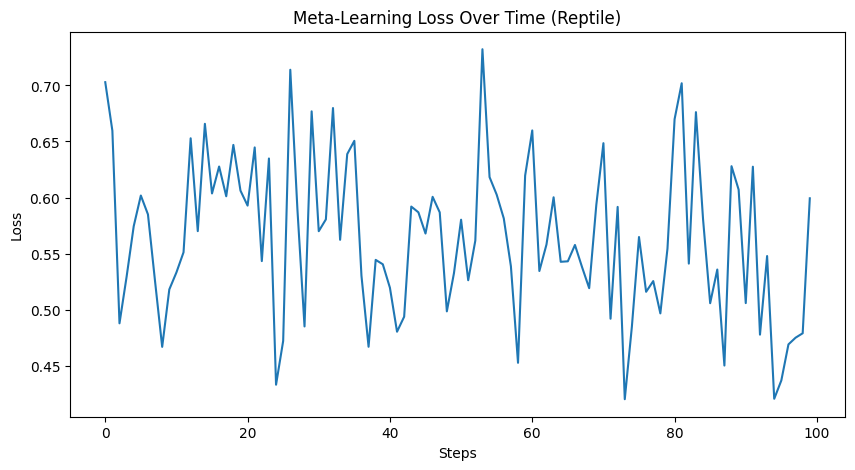

In [ ]:
num_classes = 4
num_instances = 5
num_tasks = 10
lr = 0.01  # Inner loop learning rate
meta_lr = 0.001  # Meta learning rate (controlling interpolation)
num_inner_updates = 5
num_epochs = 1000

# Initialize network and optimizer
net = ReptileLearner(num_classes)
meta_optimizer = optim.Adam(net.parameters(), lr=meta_lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(meta_optimizer, mode='min', factor=0.5, patience=50, verbose=True)
loss_metric = nn.NLLLoss()

# Get training classes
train_classes = np.max(trainframe['Label'])
train_classes = list(np.arange(train_classes))

# Train the model
meta_losses, trained_net = train(
    net, train_classes, meta_optimizer, scheduler, loss_metric,
    num_classes, num_instances, num_tasks, lr, meta_lr,
    num_inner_updates, num_epochs
)

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(meta_losses)
plt.title('Meta-Learning Loss Over Time (Reptile)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Save the model
torch.save(trained_net.state_dict(), 'reptile_resnet_model.pth')

Evaluates the trained model on test tasks.
Reports accuracy, loss distribution, and confidence intervals.

In [ ]:

def accuracy(predictions, targets):
    """
    Calculate accuracy from model predictions and targets

    Args:
        predictions: numpy array of model predictions (logits)
        targets: numpy array of true labels

    Returns:
        float: accuracy score
    """
    pred_classes = np.argmax(predictions, axis=1)
    return np.mean(pred_classes == targets)

def evaluate(net, test_classes, task_lr, num_classes=2, num_steps=500, num_eval_updates=3):
    """
    Evaluate the meta-learned model on test tasks

    Args:
        net: trained network
        test_classes: list of test classes
        task_lr: learning rate for task adaptation
        num_classes: number of classes per task
        num_steps: number of evaluation steps (tasks)
        num_eval_updates: number of gradient updates for adaptation

    Returns:
        acc_list: list of accuracies for each task
        losses: list of losses for each task
    """
    losses = []
    acc_list = []

    for step in range(num_steps):
        # Create test task
        task = TestTask(test_classes,
                       num_classes=num_classes,
                       num_instances=5,
                       num_test_instances=10)

        # Get loaders for this task
        loaders = get_test_loaders(task)
        trainloader, testloader = loaders["train"], loaders["test"]

        # Get support (train) and query (test) data
        x_train, y_train = next(iter(trainloader))
        x_test, y_test = next(iter(testloader))

        # Move to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        # Clone network for this task
        cloned_net = copy.deepcopy(net)
        cloned_net = cloned_net.to(device)

        # Create optimizer for adaptation
        optim = torch.optim.SGD(cloned_net.parameters(), lr=task_lr)

        # Adapt the model on support set
        for _ in range(num_eval_updates):
            y_train_pred = cloned_net(x_train)
            loss = loss_metric(y_train_pred, y_train)
            optim.zero_grad()
            loss.backward()
            optim.step()

        # Evaluate on query set
        with torch.no_grad():
            y_test_pred = cloned_net(x_test)
            loss = loss_metric(y_test_pred, y_test)
            losses.append(loss.item())

            # Convert predictions and labels to numpy for accuracy calculation
            y_test_pred = y_test_pred.exp().cpu().numpy()  # Convert log_softmax to probabilities
            y_test = y_test.cpu().numpy()
            acc = accuracy(y_test_pred, y_test)
            acc_list.append(acc)

        if (step + 1) % 10 == 0:
            print(f"Step {step + 1}/{num_steps}, "
                  f"Current Accuracy: {acc:.4f}, "
                  f"Average Accuracy: {np.mean(acc_list):.4f}")

    return acc_list, losses



In [ ]:
def evaluate_and_report(net, test_classes, task_lr=0.1, num_classes=2,
                       num_steps=500, num_eval_updates=3):
    """
    Evaluate the model and provide detailed reporting
    """
    print("Starting evaluation...")
    acc_list, losses = evaluate(net, test_classes, task_lr,
                              num_classes, num_steps, num_eval_updates)

    average_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)

    print("\nEvaluation Results:")
    print(f"Average Accuracy: {average_accuracy*100:.2f}%")
    print(f"Standard Deviation: {std_accuracy*100:.2f}%")
    print(f"95% Confidence Interval: "
          f"[{(average_accuracy-1.96*std_accuracy)*100:.2f}%, "
          f"{(average_accuracy+1.96*std_accuracy)*100:.2f}%]")

    # Plot accuracy distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(acc_list, bins=20, edgecolor='black')
    plt.title('Distribution of Task Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Number of Tasks')

    # Plot loss curve
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss During Evaluation')
    plt.xlabel('Task')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

    return average_accuracy, std_accuracy, acc_list, losses

Loads the trained model and evaluates it on new test tasks.
Displays metrics and visualizations for model performance.

Step 10/500, Current Accuracy: 0.5000, Average Accuracy: 0.8350
Step 20/500, Current Accuracy: 0.7500, Average Accuracy: 0.7525
Step 30/500, Current Accuracy: 1.0000, Average Accuracy: 0.8133
Step 40/500, Current Accuracy: 1.0000, Average Accuracy: 0.8113
Step 50/500, Current Accuracy: 1.0000, Average Accuracy: 0.8260
Step 60/500, Current Accuracy: 0.7500, Average Accuracy: 0.8300
Step 70/500, Current Accuracy: 0.8500, Average Accuracy: 0.8207
Step 80/500, Current Accuracy: 0.6000, Average Accuracy: 0.8319
Step 90/500, Current Accuracy: 0.5000, Average Accuracy: 0.8272
Step 100/500, Current Accuracy: 0.9500, Average Accuracy: 0.8255
Step 110/500, Current Accuracy: 0.7500, Average Accuracy: 0.8236
Step 120/500, Current Accuracy: 0.5000, Average Accuracy: 0.8179
Step 130/500, Current Accuracy: 0.9500, Average Accuracy: 0.8269
Step 140/500, Current Accuracy: 1.0000, Average Accuracy: 0.8318
Step 150/500, Current Accuracy: 0.9500, Average Accuracy: 0.8353
Step 160/500, Current Accuracy: 1.

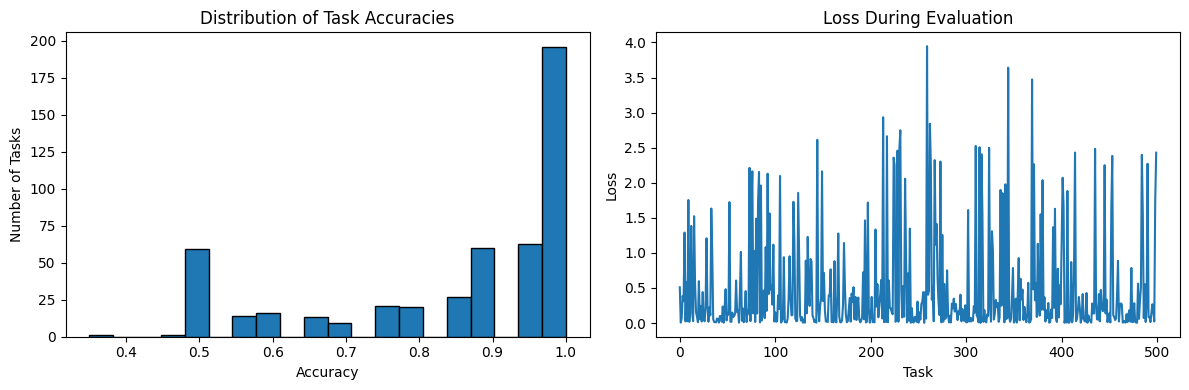

In [ ]:
net = ReptileLearner(num_classes)
net.load_state_dict(torch.load('reptile_resnet_model.pth',weights_only=True))
net = net.to(device)

# Define test classes
test_classes = list(range(np.min(testframe['Label']), np.max(testframe['Label']) + 1))

# Simple evaluation
acc_list, losses = evaluate(net, test_classes, task_lr=1e-1)
average_test_accuracy = sum(acc_list) / len(acc_list)
print(f"Average Test Accuracy: {average_test_accuracy*100:.2f}%")

# Or use the detailed evaluation with reporting
avg_acc, std_acc, acc_list, losses = evaluate_and_report(
    net,
    test_classes,
    task_lr=1e-1,
    num_classes=2,
    num_steps=500,
    num_eval_updates=3
)